In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from groupy import *
import time

In [2]:
N = 15
p = 2
X = generate_points_within_ball(N, p, 1, np.array([.5,.5]))
G = Greps_pmId

# Combinatorial Frechet Mean Computation

Frechet Functional Value: 5.947665996654695


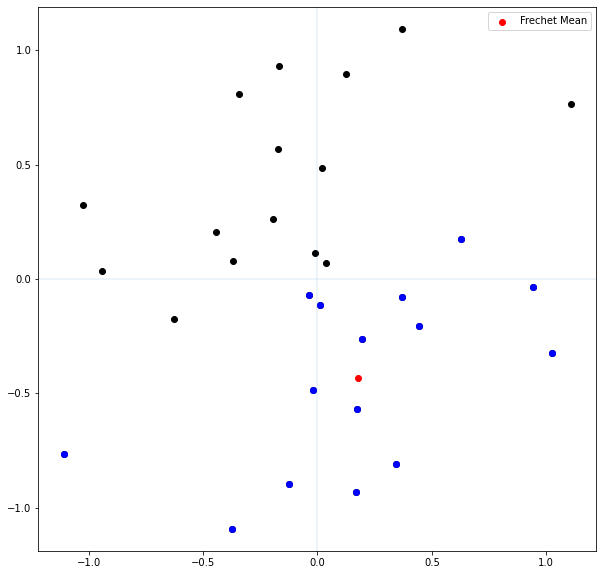

In [3]:
X_orbits = G(X)
u, Y = Frechet(X, G)

fig = plt.figure(figsize = (10,10))


plt.scatter(X_orbits[0,:], X_orbits[1,:], color = 'black')
plt.scatter(Y[0,:], Y[1,:], color = 'blue')
plt.scatter(*u.T, label = 'Frechet Mean', color = 'red')
plt.axhline(0, alpha=.1)
plt.axvline(0, alpha=.1)

plt.legend()
plt.axis('equal')

print("Frechet Functional Value:", np.sum(np.sum((Y.T-u)**2,axis=1)))

# Gradient Descent

Frechet Functional Value: 6.141973166084001


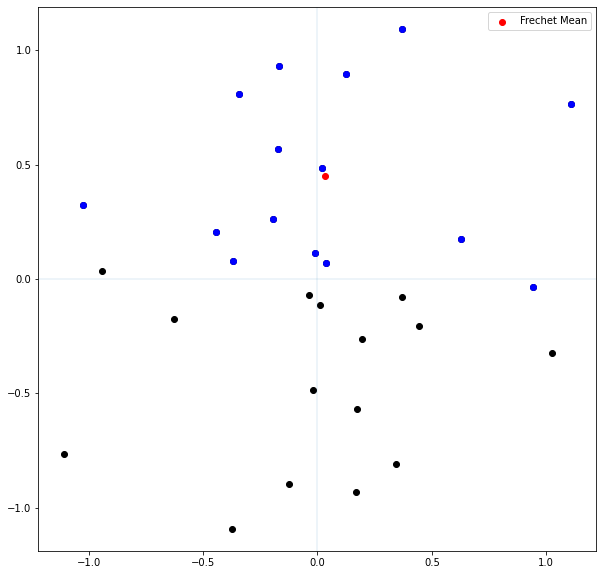

In [4]:
# start descent at a random data point
k = np.random.randint(N)

ugrad, Ygrad, niter = IterativeFrechet(X, G, X[:,k])
fig = plt.figure(figsize = (10,10))


plt.scatter(X_orbits[0,:], X_orbits[1,:], color = 'black')
plt.scatter(Ygrad[0,:], Ygrad[1,:], color = 'blue')
plt.scatter(*ugrad.T, label = 'Frechet Mean', color = 'red')
plt.axhline(0, alpha=.1)
plt.axvline(0, alpha=.1)

plt.legend()
plt.axis('equal')

print("Frechet Functional Value:", np.sum(np.sum((Ygrad.T-ugrad)**2,axis=1)))

# Spectral Relaxation

Frechet Functional Value: 5.9943390486890085


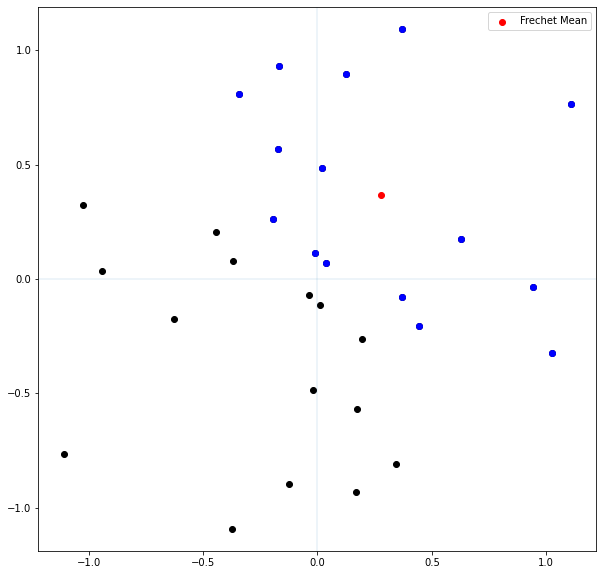

In [5]:
# round top eigenvector of Gram matrix
eps = np.sign(np.linalg.eigh(X.T @ X)[1][:,-1])

# apply optimal g_i to x_i
Yspec = eps*X
uspec = np.mean(Yspec, axis= 1)


fig = plt.figure(figsize = (10,10))


plt.scatter(X_orbits[0,:], X_orbits[1,:], color = 'black')
plt.scatter(Yspec[0,:], Yspec[1,:], color = 'blue')
plt.scatter(*uspec.T, label = 'Frechet Mean', color = 'red')
plt.axhline(0, alpha=.1)
plt.axvline(0, alpha=.1)

plt.legend()
plt.axis('equal')

print("Frechet Functional Value:", np.sum(np.sum((Yspec.T-uspec)**2,axis=1)))

# "Full Dimensionality ""Spectral Relaxation"" "

Frechet Functional Value: 6.596310651516944


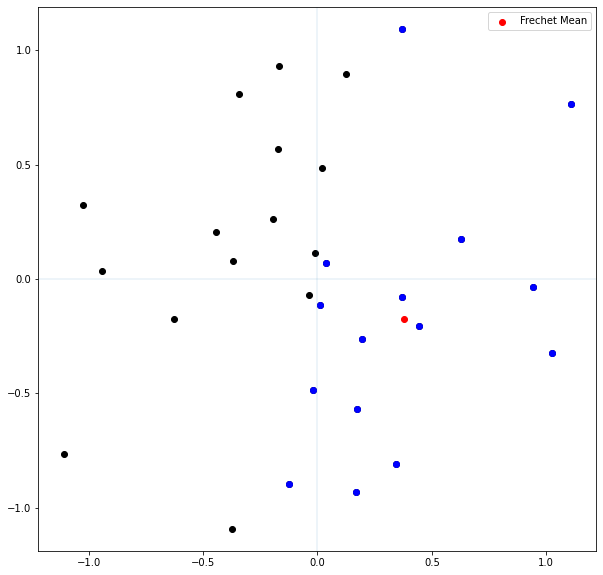

In [14]:
eps = np.ones(N)
for i in range(1, N):
    Zi = np.outer(X[:,0], X[:,i])
    eps[i] = np.sign(np.sum(np.diag(Zi)))

# apply optimal g_i to x_i
Yspec_prime = eps_prime*X
uspec_prime = np.mean(Yspec_prime, axis= 1)

fig = plt.figure(figsize = (10,10))
plt.scatter(X_orbits[0,:], X_orbits[1,:], color = 'black')
plt.scatter(Yspec_prime[0,:], Yspec_prime[1,:], color = 'blue')
plt.scatter(*uspec_prime.T, label = 'Frechet Mean', color = 'red')
plt.axhline(0, alpha=.1)
plt.axvline(0, alpha=.1)

plt.legend()
plt.axis('equal')

print("Frechet Functional Value:", np.sum(np.sum((Yspec_prime.T-uspec_prime)**2,axis=1)))

# SDP Relaxation

In [16]:
def GW_SDP(X):
    ############ ChatGPT coded

    # Define the variable Z as a p by p matrix
    Z = cp.Variable((N, N), symmetric=True)

    # Define the objective: maximize <X^T X, Z>
    objective = cp.Maximize(cp.trace((X.T @ X) @ Z))

    # Define the constraints: Z is positive semidefinite and diagonal is all ones
    constraints = [Z >> 0,  # Z is positive semidefinite
                   cp.diag(Z) == np.ones(N)]  # Diagonal of Z is all ones

    # Define the problem
    problem = cp.Problem(objective, constraints)

    # Solve the problem
    problem.solve()

    # The optimal value of Z
    Z_opt = Z.value
    #############
    
    return Z_opt

Frechet Functional Value: 5.972051597816793


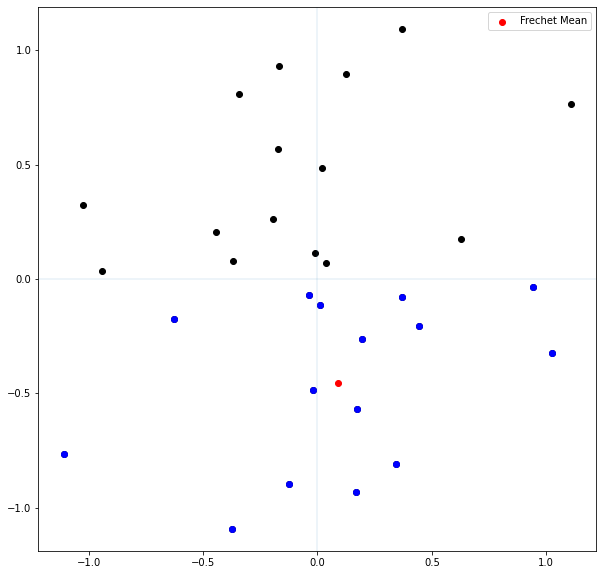

In [17]:
Z = GW_SDP(X)

evals, evecs = np.linalg.eig(Z)
eps_sdp = np.sign(evecs[:,0])

# apply optimal g_i to x_i
Ysdp = eps_sdp*X
usdp = np.mean(Ysdp, axis= 1)

fig = plt.figure(figsize = (10,10))
plt.scatter(X_orbits[0,:], X_orbits[1,:], color = 'black')
plt.scatter(Ysdp[0,:], Ysdp[1,:], color = 'blue')
plt.scatter(*usdp.T, label = 'Frechet Mean', color = 'red')
plt.axhline(0, alpha=.1)
plt.axvline(0, alpha=.1)

plt.legend()
plt.axis('equal')

print("Frechet Functional Value:", np.sum(np.sum((Ysdp.T-usdp)**2,axis=1)))

# Quick block of code to compare the methods (write into functions in groupy later)

In [46]:
NTRIALS = 1000
N = 15
p = 2
G = Greps_pmId

comb_times, grad_times, spec_times, spec_prime_times, sdp_times = [], [], [], [], []
grad_errors, spec_errors, spec_prime_errors, sdp_errors = [], [], [], []

for i in range(NTRIALS):
    X = np.random.uniform(-1, 1, size = (p,N))
    
    # Combinatorial method
    start_time = time.time()
    X_orbits = G(X)
    u, Y = Frechet(X, G)
    f_true = np.sum(np.sum((Y.T - u) ** 2, axis=1))
    comb_time = time.time() - start_time
    comb_times.append(comb_time)
    
    # Gradient descent
    start_time = time.time()
    ugrad, Ygrad, niter = IterativeFrechet(X, G, X[:, 0])
    f_grad = np.sum(np.sum((Ygrad.T - ugrad) ** 2, axis=1))
    grad_time = time.time() - start_time
    grad_error = 100 * abs(f_grad - f_true) / f_true
    grad_times.append(grad_time)
    grad_errors.append(grad_error)
    
    # Rank 1 spectral
    start_time = time.time()
    eps = np.sign(np.linalg.eigh(X.T @ X)[1][:, -1])
    Yspec = eps * X
    uspec = np.mean(Yspec, axis=1)
    f_spec = np.sum(np.sum((Yspec.T - uspec) ** 2, axis=1))
    spec_time = time.time() - start_time
    spec_error = 100 * abs(f_spec - f_true) / f_true
    spec_times.append(spec_time)
    spec_errors.append(spec_error)
    
    # Full dim spectral
    start_time = time.time()
    eps = np.ones(N)
    for i in range(1, N):
        Zi = np.outer(X[:, 0], X[:, i])
        eps[i] = np.sign(np.sum(np.diag(Zi)))
    Yspec_prime = eps * X
    uspec_prime = np.mean(Yspec_prime, axis=1)
    f_spec_prime = np.sum(np.sum((Yspec_prime.T - uspec_prime) ** 2, axis=1))
    spec_prime_time = time.time() - start_time
    spec_prime_error = 100 * abs(f_spec_prime - f_true) / f_true
    spec_prime_times.append(spec_prime_time)
    spec_prime_errors.append(spec_prime_error)
    
    # SDP
    start_time = time.time()
    Z = GW_SDP(X)
    evals, evecs = np.linalg.eig(Z)
    eps_sdp = np.sign(evecs[:, 0])
    Ysdp = eps_sdp * X
    usdp = np.mean(Ysdp, axis=1)
    f_sdp = np.sum(np.sum((Ysdp.T - usdp) ** 2, axis=1))
    sdp_time = time.time() - start_time
    sdp_error = 100 * abs(f_sdp - f_true) / f_true
    sdp_times.append(sdp_time)
    sdp_errors.append(sdp_error)

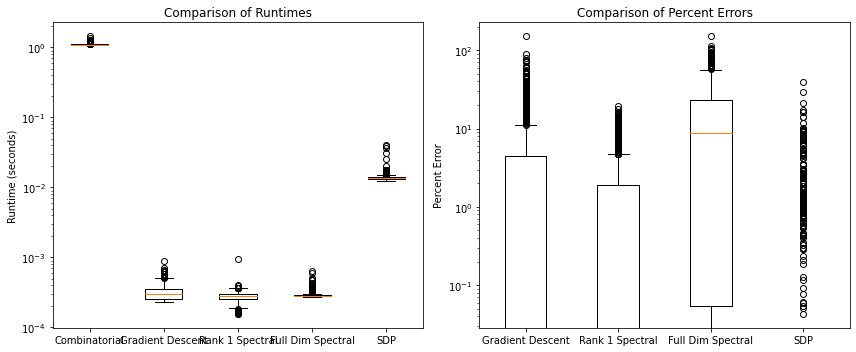

In [47]:
# Plot results
methods = ["Combinatorial", "Gradient Descent", "Rank 1 Spectral", "Full Dim Spectral", "SDP"]
time_data = [comb_times, grad_times, spec_times, spec_prime_times, sdp_times]
error_data = [grad_errors, spec_errors, spec_prime_errors, sdp_errors]

plt.figure(figsize=(12, 5))

# Runtime plot
plt.subplot(1, 2, 1)
plt.boxplot(time_data, labels=methods)
plt.ylabel("Runtime (seconds)")
plt.yscale('log')
plt.title("Comparison of Runtimes")

# Error plot
plt.subplot(1, 2, 2)
plt.boxplot(error_data, labels=methods[1:])
plt.ylabel("Percent Error")
plt.yscale('log')
plt.title("Comparison of Percent Errors")

plt.tight_layout()
plt.show()

In [8]:
# # nd column vector of stacked x_i
# x = X.flatten('F').reshape(-1,1)

# # round top eigenvector of Gram matrix
# evals, evecs = np.linalg.eigh(np.outer(x,x))
# # order DECREASING
# evecs = evecs[:,::-1]
# evals = evals[::-1]
# # largest p evecs in dec order
# Y = evecs[:,:p]

# # # determine eps by looking at g_i formed by eigenvectors -- depends on ordering of eigenvectors
# # matrix Y such that YY^T is the rank p approx to xx^T
# # Y = np.sqrt(evals[:p]) * Y
# # eps_prime = [np.sign(np.sum(np.diag(Y[2*i:2*(i+1), :]))) for i in range(N)]

# # determine YY^T then get matchings based on first row
# Z = Y @ np.diag(evals[:p]) @ Y.T
# eps_prime = np.ones(N)
# # register g_1=1 then get matchings
# for i in range(1, N):
#     Zblock = Z[:p, 2*i:2*(i+1)]
#     eps_prime[i] = np.sign(np.sum(np.diag(Zblock)))

# # apply optimal g_i to x_i
# Yspec_prime = eps_prime*X
# uspec_prime = np.mean(Yspec_prime, axis= 1)

# fig = plt.figure(figsize = (10,10))
# plt.scatter(X_orbits[0,:], X_orbits[1,:], color = 'black')
# plt.scatter(Yspec_prime[0,:], Yspec_prime[1,:], color = 'blue')
# plt.scatter(*uspec_prime.T, label = 'Frechet Mean', color = 'red')
# plt.axhline(0, alpha=.1)
# plt.axvline(0, alpha=.1)

# plt.legend()
# plt.axis('equal')

# print("Frechet Functional Value:", np.sum(np.sum((Yspec_prime.T-uspec_prime)**2,axis=1)))

# ^ Old Full Dim Spectral Code: (may be useful but probably just not as good)